# Rank Dynamics Exploration

This notebook is for interactive analysis of rank decay dynamics from Weights & Biases logs.

In [8]:
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from architectural_and_learning_on_loss_landscape.src.utils.zeroth_order_features import compute_rank_decay_dynamics

# --- Configuration ---
RUN_PATH = "alvin-wb/drifting_experiment_continuous_input_deformation/1kx17wke"  # <-- REPLACE with your entity/project/run_id
RANK_TYPE = "effective_rank"  # or 'approximate_rank', 'numerical_rank', etc.
ANALYSIS_MODE = 'difference' # 'difference' or 'ratio'

# Note: The notebook now automatically discovers layer order using robust methods.
# Manual specification is only needed if automatic discovery fails.

In [9]:
import sys
import os
sys.path.append('/hdda/models/my_own_models')
from architectural_and_learning_on_loss_landscape.src.utils.zeroth_order_features import compute_rank_decay_dynamics

In [10]:
# Import the robust utility functions from our analysis module
import sys
import os
analysis_dir = os.path.join(os.path.dirname(os.getcwd()), 'analysis')
sys.path.append(analysis_dir)

from plot_rank_dynamics import get_correct_layer_order, simple_fallback_sort, discover_and_sort_rank_keys

# Initialize W&B API and get run
api = wandb.Api()
run = api.run(RUN_PATH)

print(f"🔍 Analyzing run: {run.name}")
print(f"📊 Looking for rank type: {RANK_TYPE}")

# Use the robust layer discovery function
rank_keys = discover_and_sort_rank_keys(run, RANK_TYPE)

if rank_keys is None:
    print("\n" + "="*50)
    print("❌ MANUAL LAYER ORDER REQUIRED")
    print("="*50)
    print("The automatic layer discovery failed.")
    print("Please specify the correct layer order manually:")
    print()
    print("# Uncomment and modify the line below:")
    print("# MANUAL_LAYER_ORDER = ['conv1', 'conv2', 'fc1']  # Your actual layer names")
    print()
    print("Then run the following code:")
    print("# rank_keys = [f'{name}_{RANK_TYPE}' for name in MANUAL_LAYER_ORDER]")
    print("="*50)
    
    # You can also make this interactive for Jupyter:
    # MANUAL_LAYER_ORDER = input("Enter layer names separated by commas: ").split(',')
    # rank_keys = [f"{name.strip()}_{RANK_TYPE}" for name in MANUAL_LAYER_ORDER]
    
    raise ValueError("Manual layer order specification required. See instructions above.")

print(f"\n✅ Successfully determined layer order!")
print(f"📋 Using {len(rank_keys)} layers:")
for i, key in enumerate(rank_keys):
    layer_name = key.replace(f'_{RANK_TYPE}', '')
    print(f"   {i+1}. {layer_name}")

# --- Fetch Data using Discovered Keys ---
print(f"\n🔄 Fetching history for {len(rank_keys)} metrics...")
scan = run.scan_history(keys=rank_keys)
history_list = [row for row in scan]
history = pd.DataFrame(history_list)

print(f"✅ Successfully fetched {len(history)} steps from run: {run.name}")
print(f"📊 DataFrame columns: {list(history.columns)}")
history.head()

🔍 Analyzing run: swept-plasma-41
📊 Looking for rank type: effective_rank
=== Starting Layer Order Discovery ===
🔧 Reconstructing model to get correct layer order...
⚠️  Could not import required modules: No module named 'src'
⚠️  Model reconstruction not possible, using fallback methods...
🔍 Discovering available rank keys from W&B run...
📊 Found 5 keys ending with '_effective_rank'
   Keys: ['conv1_pooled_effective_rank', 'conv2_pooled_effective_rank', 'conv3_flattened_effective_rank', 'fc1_output(with ln)_effective_rank', 'fc2_output(with ln)_effective_rank']
⚠️  Found semantic layer names that require manual ordering: ['conv1_pooled', 'conv2_pooled', 'conv3_flattened', 'fc1_output(with ln)', 'fc2_output(with ln)']
❌ Cannot automatically sort semantic layer names.
   Please specify the layer order manually in your configuration.

❌ ERROR: Cannot automatically determine layer order!
🔧 SOLUTION: Please specify the layer order manually.
   Example for script usage:
   MANUAL_LAYER_ORDER

ValueError: Manual layer order specification required. See instructions above.

In [ ]:
# ===== MANUAL OVERRIDE (if needed) =====
# Uncomment and modify this section if automatic discovery fails:

# MANUAL_LAYER_ORDER = ['conv1', 'conv2', 'fc1']  # <-- Specify your actual layer names here
# rank_keys = [f"{name}_{RANK_TYPE}" for name in MANUAL_LAYER_ORDER]
# print(f"🔧 Using manual layer order: {MANUAL_LAYER_ORDER}")

# Then skip to the data fetching section below

## Fetch Data from W&B

In [ ]:
import re

api = wandb.Api()
run = api.run(RUN_PATH)

# --- Enhanced Dynamic Key Discovery and Sorting ---

# 1. Get all metric keys from the run's history/summary
all_keys = run.summary.keys()

# 2. Filter for the keys that match our desired rank type suffix
rank_suffix = f"_{RANK_TYPE}"
discovered_keys = [key for key in all_keys if key.endswith(rank_suffix)]

print("--- Key Discovery Debug ---")
print(f"Total keys in run: {len(all_keys)}")
print(f"Keys ending with '{rank_suffix}': {len(discovered_keys)}")
if len(discovered_keys) <= 10:  # Only print if not too many
    print("Discovered keys:", discovered_keys)
print("----------------------------")

# Verify that keys were found
if not discovered_keys:
    raise ValueError(f"Error: No keys found in the run ending with '{rank_suffix}'. Please check RANK_TYPE and your W&B logs.")

# 3. Advanced sorting with layer ordering logic
def enhanced_layer_sort_key(key_name):
    """
    Enhanced sorting that understands common layer naming patterns:
    - conv1, conv2, ... (convolutional layers)
    - fc1, fc2, ... (fully connected layers) 
    - layer_0, layer_1, ... (generic indexed layers)
    - Assumes conv layers come before fc layers
    """
    # Remove the rank suffix to get the layer name
    layer_name = key_name.replace(rank_suffix, '')
    
    # Extract numbers and text parts
    parts = re.split('([0-9]+)', layer_name.lower())
    
    # Assign priority: conv < fc < generic layer names
    if 'conv' in layer_name.lower():
        priority = 0
    elif 'fc' in layer_name.lower() or 'linear' in layer_name.lower():
        priority = 1
    elif 'layer_' in layer_name.lower():
        priority = 2
    else:
        priority = 3  # Unknown naming scheme
    
    # Convert numeric parts to integers for proper ordering
    sort_parts = []
    for part in parts:
        if part.isdigit():
            sort_parts.append(int(part))
        else:
            sort_parts.append(part)
    
    return (priority, sort_parts)

# 4. Check if layer order is stored in W&B config (best case)
layer_order_from_config = None
try:
    if hasattr(run, 'config') and 'layer_order' in run.config:
        layer_order_from_config = run.config['layer_order']
        print(f"✓ Found layer order in W&B config: {layer_order_from_config}")
        # Create ordered keys based on config
        rank_keys = [f"{layer_name}{rank_suffix}" for layer_name in layer_order_from_config 
                    if f"{layer_name}{rank_suffix}" in discovered_keys]
    else:
        print("ℹ No layer order found in W&B config, using heuristic sorting")
        layer_order_from_config = None
except Exception as e:
    print(f"⚠ Could not read W&B config: {e}")
    layer_order_from_config = None

# 5. Fall back to heuristic sorting if no config available
if layer_order_from_config is None:
    discovered_keys.sort(key=enhanced_layer_sort_key)
    rank_keys = discovered_keys

print("\\n--- Final Layer Order ---")
print(f"Using {len(rank_keys)} layers in this order:")
for i, key in enumerate(rank_keys):
    layer_name = key.replace(rank_suffix, '')
    print(f"  {i+1}. {layer_name} -> {key}")
print("------------------------\\n")

# 6. Manual override option (uncomment and modify if needed)
# MANUAL_LAYER_ORDER = ['conv1', 'conv2', 'fc1']  # Specify your desired order here
# if 'MANUAL_LAYER_ORDER' in locals():
#     print("🔧 Using manual layer order override")
#     rank_keys = [f"{layer_name}{rank_suffix}" for layer_name in MANUAL_LAYER_ORDER 
#                 if f"{layer_name}{rank_suffix}" in discovered_keys]

# --- Fetch Data using Discovered Keys ---
print(f"Fetching history for {len(rank_keys)} metrics...")
scan = run.scan_history(keys=rank_keys)
history_list = [row for row in scan]
history = pd.DataFrame(history_list)

print(f"Successfully fetched {len(history)} steps from run: {run.name}")
print(f"DataFrame columns: {list(history.columns)}")
history.head()

--- Key Discovery Debug ---
Total keys in run: 34
Keys ending with '_effective_rank': 5
Discovered keys: ['conv1_pooled_effective_rank', 'conv2_pooled_effective_rank', 'conv3_flattened_effective_rank', 'fc1_output(with ln)_effective_rank', 'fc2_output(with ln)_effective_rank']
----------------------------
ℹ No layer order found in W&B config, using heuristic sorting
\n--- Final Layer Order ---
Using 5 layers in this order:
  1. conv1_pooled -> conv1_pooled_effective_rank
  2. conv2_pooled -> conv2_pooled_effective_rank
  3. conv3_flattened -> conv3_flattened_effective_rank
  4. fc1_output(with ln) -> fc1_output(with ln)_effective_rank
  5. fc2_output(with ln) -> fc2_output(with ln)_effective_rank
------------------------\n
Fetching history for 5 metrics...
Successfully fetched 25000 steps from run: swept-plasma-41
DataFrame columns: ['conv1_pooled_effective_rank', 'conv2_pooled_effective_rank', 'conv3_flattened_effective_rank', 'fc1_output(with ln)_effective_rank', 'fc2_output(with ln)

,conv1_pooled_effective_rank,conv2_pooled_effective_rank,conv3_flattened_effective_rank,fc1_output(with ln)_effective_rank,fc2_output(with ln)_effective_rank
0,333.819916,355.309113,57.576656,52.206394,48.497379
1,342.966461,370.738098,58.691490,51.736233,43.918465
2,338.777374,382.263336,61.679234,52.444794,39.891811
3,331.238068,382.954071,63.714169,51.225761,35.713783
4,335.093567,386.833527,63.383266,48.208176,31.272861


## Compute Derived Dynamics Metrics

In [ ]:
# Enhanced plotting section with individual layer ranks
import numpy as np

# Create enhanced plots with individual layer ranks
fig, axes = plt.subplots(4, 1, figsize=(14, 20), sharex=True)
fig.suptitle(f'Rank Dynamics Analysis for Run: {run.name}\n(Rank Type: {RANK_TYPE}, Mode: {ANALYSIS_MODE})', fontsize=16)

# Plot 1: Individual Layer Ranks Over Time
print(f"📈 Plotting individual layer ranks for {len(rank_keys)} layers...")
colors = plt.cm.Set1(np.linspace(0, 1, len(rank_keys)))
for i, (key, color) in enumerate(zip(rank_keys, colors)):
    layer_name = key.replace(f'_{RANK_TYPE}', '')
    axes[0].plot(history_cleaned['_step'], history_cleaned[key], 
                label=f'Layer {i+1}: {layer_name}', color=color, linewidth=2)

axes[0].set_title(f'Individual Layer {RANK_TYPE.replace("_", " ").title()} vs. Training Step')
axes[0].set_ylabel(f'{RANK_TYPE.replace("_", " ").title()}')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plot 2: Rank Drop Gini Coefficient
axes[1].plot(dynamics_df['_step'], dynamics_df['rank_drop_gini'], 
            label='Gini Coefficient', color='red', linewidth=2)
axes[1].set_title('Rank Drop Gini Coefficient vs. Training Step')
axes[1].set_ylabel('Gini Coefficient')
axes[1].grid(True, linestyle='--', alpha=0.7)

# Plot 3: Rank Decay Centroid
axes[2].plot(dynamics_df['_step'], dynamics_df['rank_decay_centroid'], 
            label='Rank Decay Centroid', color='blue', linewidth=2)
axes[2].set_title('Rank Decay Centroid vs. Training Step')
axes[2].set_ylabel('Centroid (Layer Index)')
axes[2].grid(True, linestyle='--', alpha=0.7)

# Plot 4: Normalized AURC
axes[3].plot(dynamics_df['_step'], dynamics_df['normalized_aurc'], 
            label='Normalized AURC', color='green', linewidth=2)
axes[3].set_title('Normalized AURC vs. Training Step')
axes[3].set_ylabel('Normalized Area Under Rank Curve')
axes[3].set_xlabel('Training Step')
axes[3].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Create a summary of the layer information
print("\n📋 Layer Summary:")
print("="*60)
for i, key in enumerate(rank_keys):
    layer_name = key.replace(f'_{RANK_TYPE}', '')
    final_rank = history_cleaned[key].iloc[-1]
    initial_rank = history_cleaned[key].iloc[0]
    rank_change = final_rank - initial_rank
    print(f"Layer {i+1}: {layer_name}")
    print(f"  Initial {RANK_TYPE}: {initial_rank:.2f}")
    print(f"  Final {RANK_TYPE}: {final_rank:.2f}")
    print(f"  Change: {rank_change:+.2f}")
    print()
    
print("="*60)
print(f"Analysis complete for {len(history_cleaned)} training steps")

Original history length: 25000
Cleaned history length (rows with complete rank data): 25000


KeyError: '_step'

## Plot the Results

KeyError: '_step'

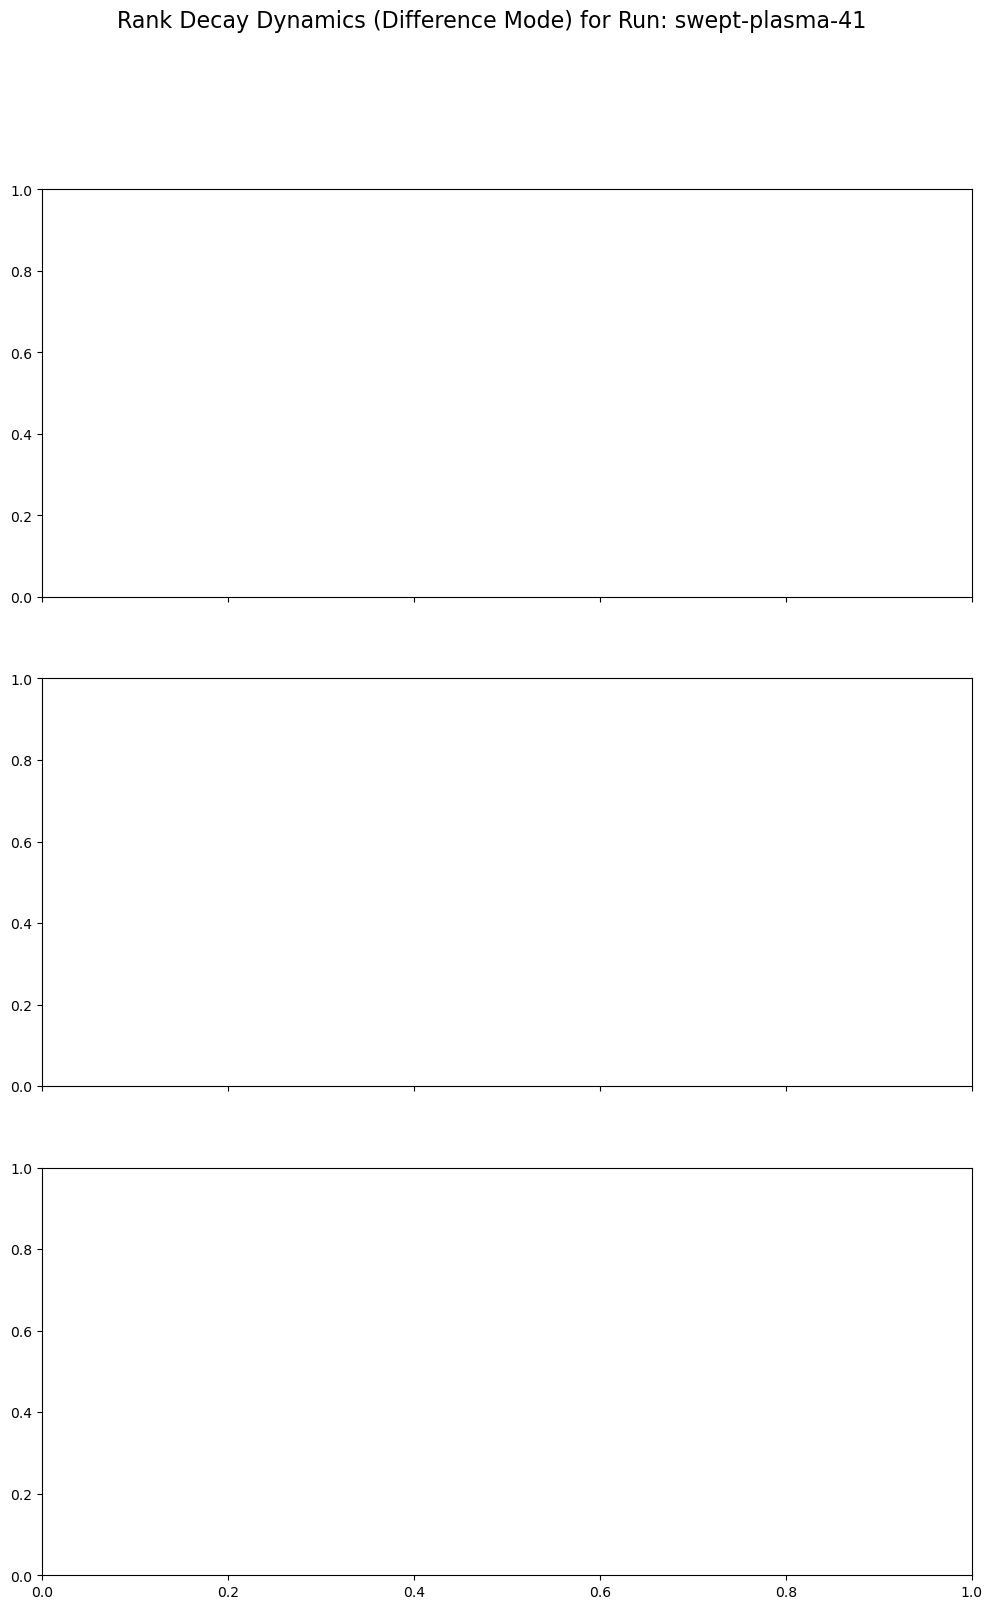

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)
fig.suptitle(f'Rank Decay Dynamics ({ANALYSIS_MODE.capitalize()} Mode) for Run: {run.name}', fontsize=16)

# Plot Gini Coefficient
axes[0].plot(dynamics_df['_step'], dynamics_df['rank_drop_gini'], label='Gini Coefficient')
axes[0].set_title('Rank Drop Gini Coefficient vs. Training Step')
axes[0].set_ylabel('Gini Coefficient')
axes[0].grid(True, linestyle='--')

# Plot Rank Decay Centroid
axes[1].plot(dynamics_df['_step'], dynamics_df['rank_decay_centroid'], label='Rank Decay Centroid')
axes[1].set_title('Rank Decay Centroid vs. Training Step')
axes[1].set_ylabel('Centroid (Layer Index)')
axes[1].grid(True, linestyle='--')

# Plot Normalized AURC
axes[2].plot(dynamics_df['_step'], dynamics_df['normalized_aurc'], label='Normalized AURC')
axes[2].set_title('Normalized AURC vs. Training Step')
axes[2].set_ylabel('Normalized Area')
axes[2].set_xlabel('Training Step')
axes[2].grid(True, linestyle='--')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()